# Salt Lake City Historical Real Estate Data

## Exploring the Zillow Research Data Sets and Extracting SLC Relevant Data

In [208]:
import warnings
warnings.filterwarnings('ignore')

In [209]:
import os.path
import pandas as pd
import urllib.parse
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
import numpy as np

In [210]:
# import csv for downloaded from Zillow Research 'Home Values'

zr_data_set_loc = '/Users/jeff/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_research_home_values'
one_br_df = pd.read_csv(os.path.join(zr_data_set_loc, 'Zip_Zhvi_1bedroom.csv'))
two_br_df = pd.read_csv(os.path.join(zr_data_set_loc, 'Zip_Zhvi_2bedroom.csv'))
three_br_df = pd.read_csv(os.path.join(zr_data_set_loc, 'Zip_Zhvi_3bedroom.csv'))
four_br_df = pd.read_csv(os.path.join(zr_data_set_loc, 'Zip_Zhvi_4bedroom.csv'))
five_or_more_br_df = pd.read_csv(os.path.join(zr_data_set_loc, 'Zip_Zhvi_5BedroomOrMore.csv'))

In [211]:
# adding a column for bedroom number; 5 or more will be categorized as 5
one_br_df['beds'] = 1
two_br_df['beds'] = 2
three_br_df['beds'] = 3
four_br_df['beds'] = 4
five_or_more_br_df['beds'] = 5

In [212]:
# concatenate all bedrooms listing into one data frame
listings_historical = pd.concat([one_br_df, two_br_df, three_br_df, four_br_df, five_or_more_br_df])

# pull out only Utah listings
listings_historical_UT = listings_historical[listings_historical['State'] == 'UT']

# pull out only listings relevant to our zip codes of interest

slc_zip_list = [84101, 84102, 84103, 84104, 84105, 84106, 84107, 84108, 84109, 84111, 84115, 
                84054, 84119, 84116, 84117, 84118, 84120, 84121, 84123, 84124, 84128, 84129, 
                84010, 84087]

listings_historical_slc = listings_historical_UT[listings_historical_UT['RegionName'].isin(slc_zip_list)]

In [214]:
# import zip_to_neighborhood
zip_to_neighborhood = pd.read_csv('/Users/jeff/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_analysis_notebooks/zip_codes_to_neighborhood.csv', 
                           sep=',')
zip_to_neighborhood['postal_code'].unique()

array([84121, 84103, 84108, 84117, 84106, 84109, 84119, 84107, 84128,
       84124, 84105, 84102, 84101, 84120, 84115, 84123, 84118, 84129,
       84111, 84104, 84116, 84054, 84010, 84114, 84087])

In [215]:
# zip code name name to RegionName to make joining easy

zip_to_neighborhood.columns = ['RegionName', 'neighborhood']

# join neighborhood classifications to the existing data frame

listings_historical_slc = pd.merge(listings_historical_slc, zip_to_neighborhood, on='RegionName', how='outer')

In [216]:
# import neighborhood_to_region
neighborhood_to_region = pd.read_csv('/Users/jeff/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_analysis_notebooks/neighborhood_to_region.csv', 
                           sep=',')

# zip code name name to RegionName to make joining easy

neighborhood_to_region.columns = ['neighborhood', 'region']

# join neighborhood classifications to the existing data frame

listings_historical_slc = pd.merge(listings_historical_slc, neighborhood_to_region, on='neighborhood', how='outer')

In [218]:
# rename RegionName with postal_code to match the current listings data set
listings_historical_slc["postal_code"] = listings_historical_slc['RegionName']

# create a trimmed df of only time series data + the city_zip field as an index

listings_historical_slc = listings_historical_slc.drop(['RegionID','RegionName','City',
                                          'State','Metro','CountyName','SizeRank'], axis = 1)
# index the time series df to city_zip

listings_historical_slc.reset_index(drop=True, inplace=True)

In [219]:
# setting up melt categories
ids = ['beds',
'neighborhood',
'postal_code',
'region']

values = list(listings_historical_slc.columns)[:-4]

In [220]:
# 'melt' the data frame to create a long format; better for plotting time series

listings_historical_slc_long = pd.melt(listings_historical_slc, id_vars=ids, value_vars=values)

# rename the headers

listings_historical_slc_long.columns = ['beds', 'neighborhood', 'postal_code', 'region', 'year_month', 'price']

# convert the date column from a strind to a date time object

listings_historical_slc_long['year_month'] = pd.to_datetime(listings_historical_slc_long['year_month'], format='%Y-%m', errors='coerce').dropna()

In [226]:
# make dict of all combinations of zip code/bedrooms
zipcode_list = list(listings_historical_slc_long['postal_code'].unique())
bed_list = list(range(1,6))
zipcode_bed_perms = {k:v for k,v in zip(zipcode_list, [bed_list]*len(zipcode_list))}

# for each location/bed of home normalize to price at starting time stamp and save to dictionary
listings_historical_slc_long_adjusted = pd.DataFrame()

for zc,bds in zipcode_bed_perms.items():
    zipcode = zc
    for num in bds:
        beds = num
        zipcode_beds = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == int(zipcode))
                                                                       &(listings_historical_slc_long['beds'] == beds)].dropna(axis=0, how='any')
        if len(zipcode_beds) > 0:
            min_year = min(zipcode_beds['year_month'])
            start_price = int((zipcode_beds['price'][zipcode_beds['year_month'] == min_year]).values)
            zipcode_beds['price_normalized'] = (zipcode_beds['price']) / start_price
            zipcode_beds['price_normalized_date'] = min_year
            listings_historical_slc_long_adjusted = listings_historical_slc_long_adjusted.append(zipcode_beds)
        else:
            pass

## Exporting the Cleaned, Processed Active Listing Data

Here I exported the data frame to a csv so the fully processed data could be imported to the project overview notebook for summary visualizations.

In [227]:
listings_historical_slc_long_adjusted.to_csv('zillow_slc_historic_prices_processed.csv')

### Plotting the Data

Now that the data is normalized for each zip code- bed number, let's plot the time series data.

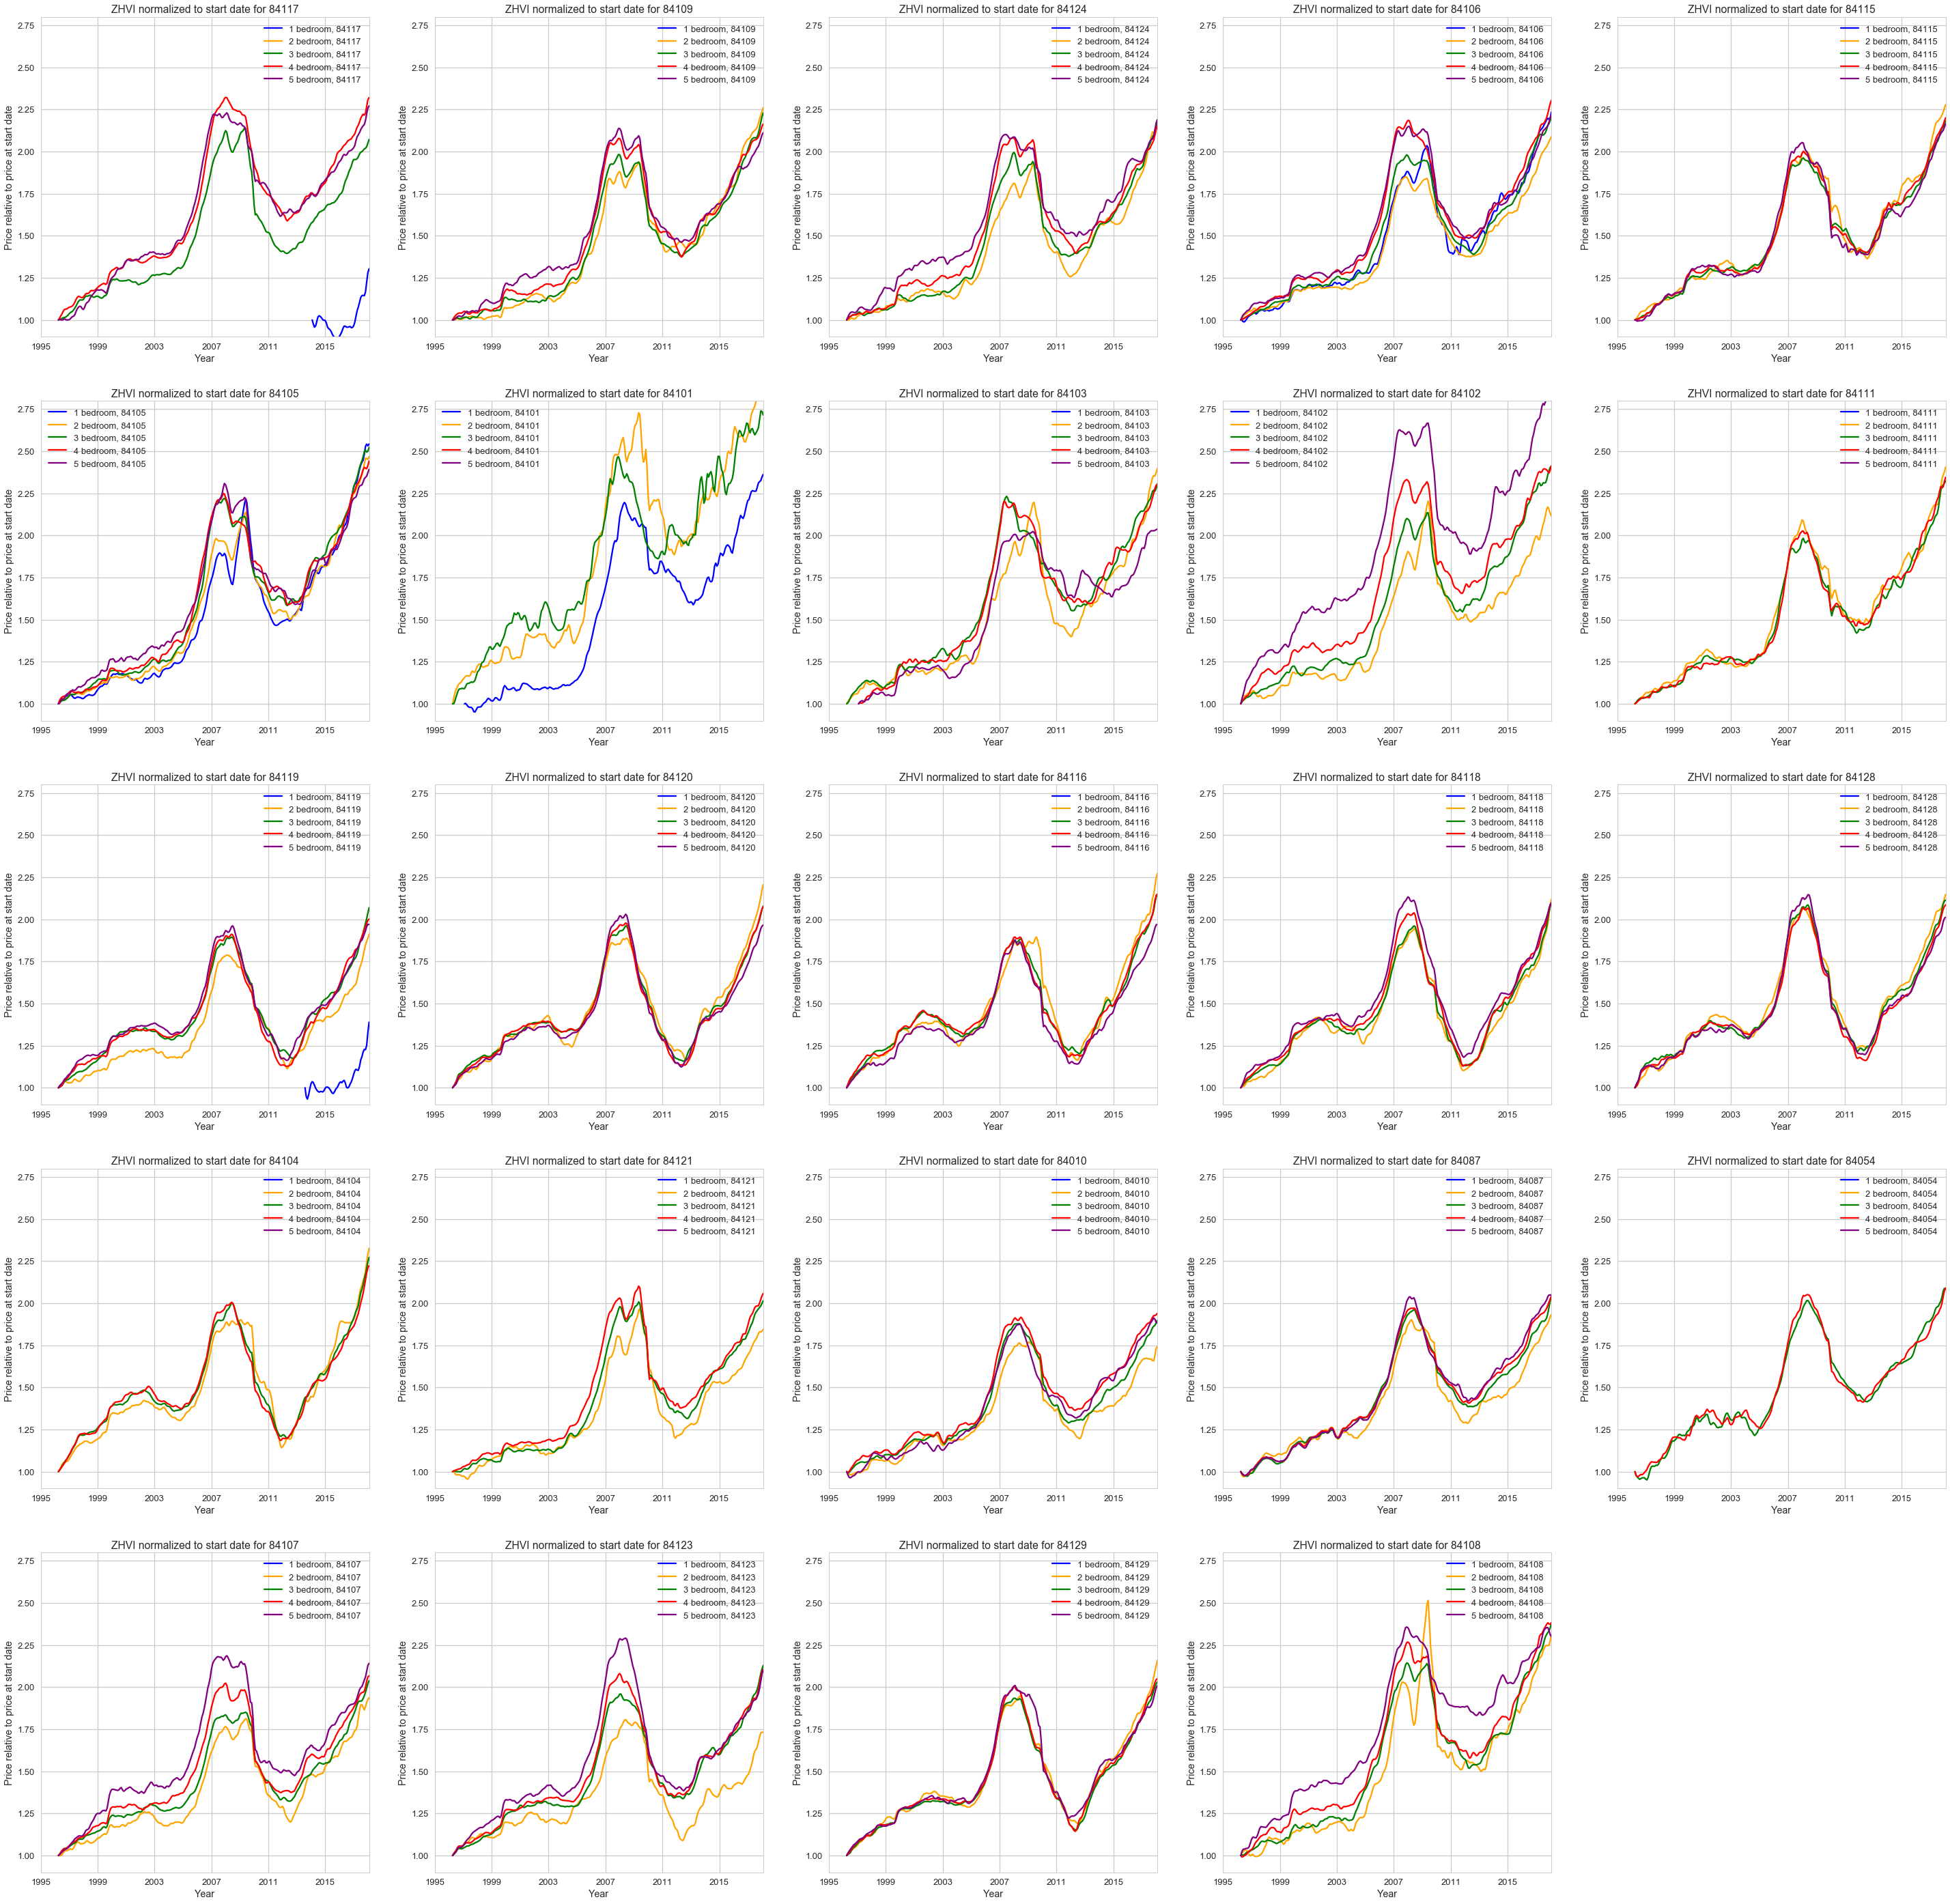

In [239]:
import datetime

# plot normalized price value across timeseries for all zip codes

# make dict of all combinations of zip code/bedrooms
zipcode_list = list(listings_historical_slc_long_adjusted['postal_code'].unique())
bed_list = list(range(1,6))
zipcode_bed_perms = {k:v for k,v in zip(zipcode_list, [bed_list]*len(zipcode_list))}

#make the axes fonts bigger
sns.set_context("talk")
sns.set_style("whitegrid")
fig = plt.figure(figsize=[50, 50])

sub_plot_num = 1

for zc,bds in zipcode_bed_perms.items():
    zipcode = zc
    zipcode_all_beds = listings_historical_slc_long_adjusted[(listings_historical_slc_long_adjusted['postal_code'] == 
                                                             int(zipcode))].dropna(axis=0, how='any')
    fig.add_subplot(5, 5, sub_plot_num)
    for num in bds:
        beds = num
        zipcode_num_beds = zipcode_all_beds[zipcode_all_beds['beds']==num]
        col=['blue', 'orange', 'green', 'red', 'purple']
        plt.plot(zipcode_num_beds['year_month'], zipcode_num_beds['price_normalized'], color = col[num-1], label='{} bedroom, {}'.format(num, zc))
        plt.title('ZHVI normalized to start date for {}'.format(zipcode))
        plt.ylabel('Price relative to price at start date')
        plt.xlabel('Year')
        plt.ylim((0.9, 2.8))
        plt.xlim(datetime.date(1995, 1, 1), datetime.date(2018, 2, 1)) 
        plt.legend()
    sub_plot_num +=1

In [240]:
listings_historical_slc_long_adjusted[listings_historical_slc_long_adjusted['year_month']
                                      =='2018-02-01'].sort_values('price_normalized', ascending=False).head(n=10)

,beds,neighborhood,postal_code,region,year_month,price,price_normalized,price_normalized_date
24655,2.0,Downtown_SLC,84101,Central,2018-02-01,336300.0,2.894148,1996-04-01
24664,5.0,Downtown_SLC,84102,Central,2018-02-01,481900.0,2.821429,1996-04-01
24656,3.0,Downtown_SLC,84101,Central,2018-02-01,315800.0,2.715391,1996-04-01
24649,1.0,Downtown_SLC,84105,Central,2018-02-01,293500.0,2.543328,1996-04-01
24651,3.0,Downtown_SLC,84105,Central,2018-02-01,376700.0,2.523108,1996-04-01
24650,2.0,Downtown_SLC,84105,Central,2018-02-01,319400.0,2.468315,1996-04-01
24652,4.0,Downtown_SLC,84105,Central,2018-02-01,424400.0,2.441887,1996-04-01
24663,4.0,Downtown_SLC,84102,Central,2018-02-01,371300.0,2.414174,1996-04-01
24662,3.0,Downtown_SLC,84102,Central,2018-02-01,333000.0,2.413043,1996-04-01
24665,2.0,Downtown_SLC,84111,Central,2018-02-01,220600.0,2.405671,1996-04-01


In [243]:
# collapse neighborhoods with multiple zip codes to reflect average value of neighborhood across all zip codes
listings_historical_neibs = pd.DataFrame(listings_historical_slc_long_adjusted.groupby(['year_month','neighborhood', 'beds']).mean())

listings_historical_neibs_collapsed = listings_historical_neibs.reset_index()

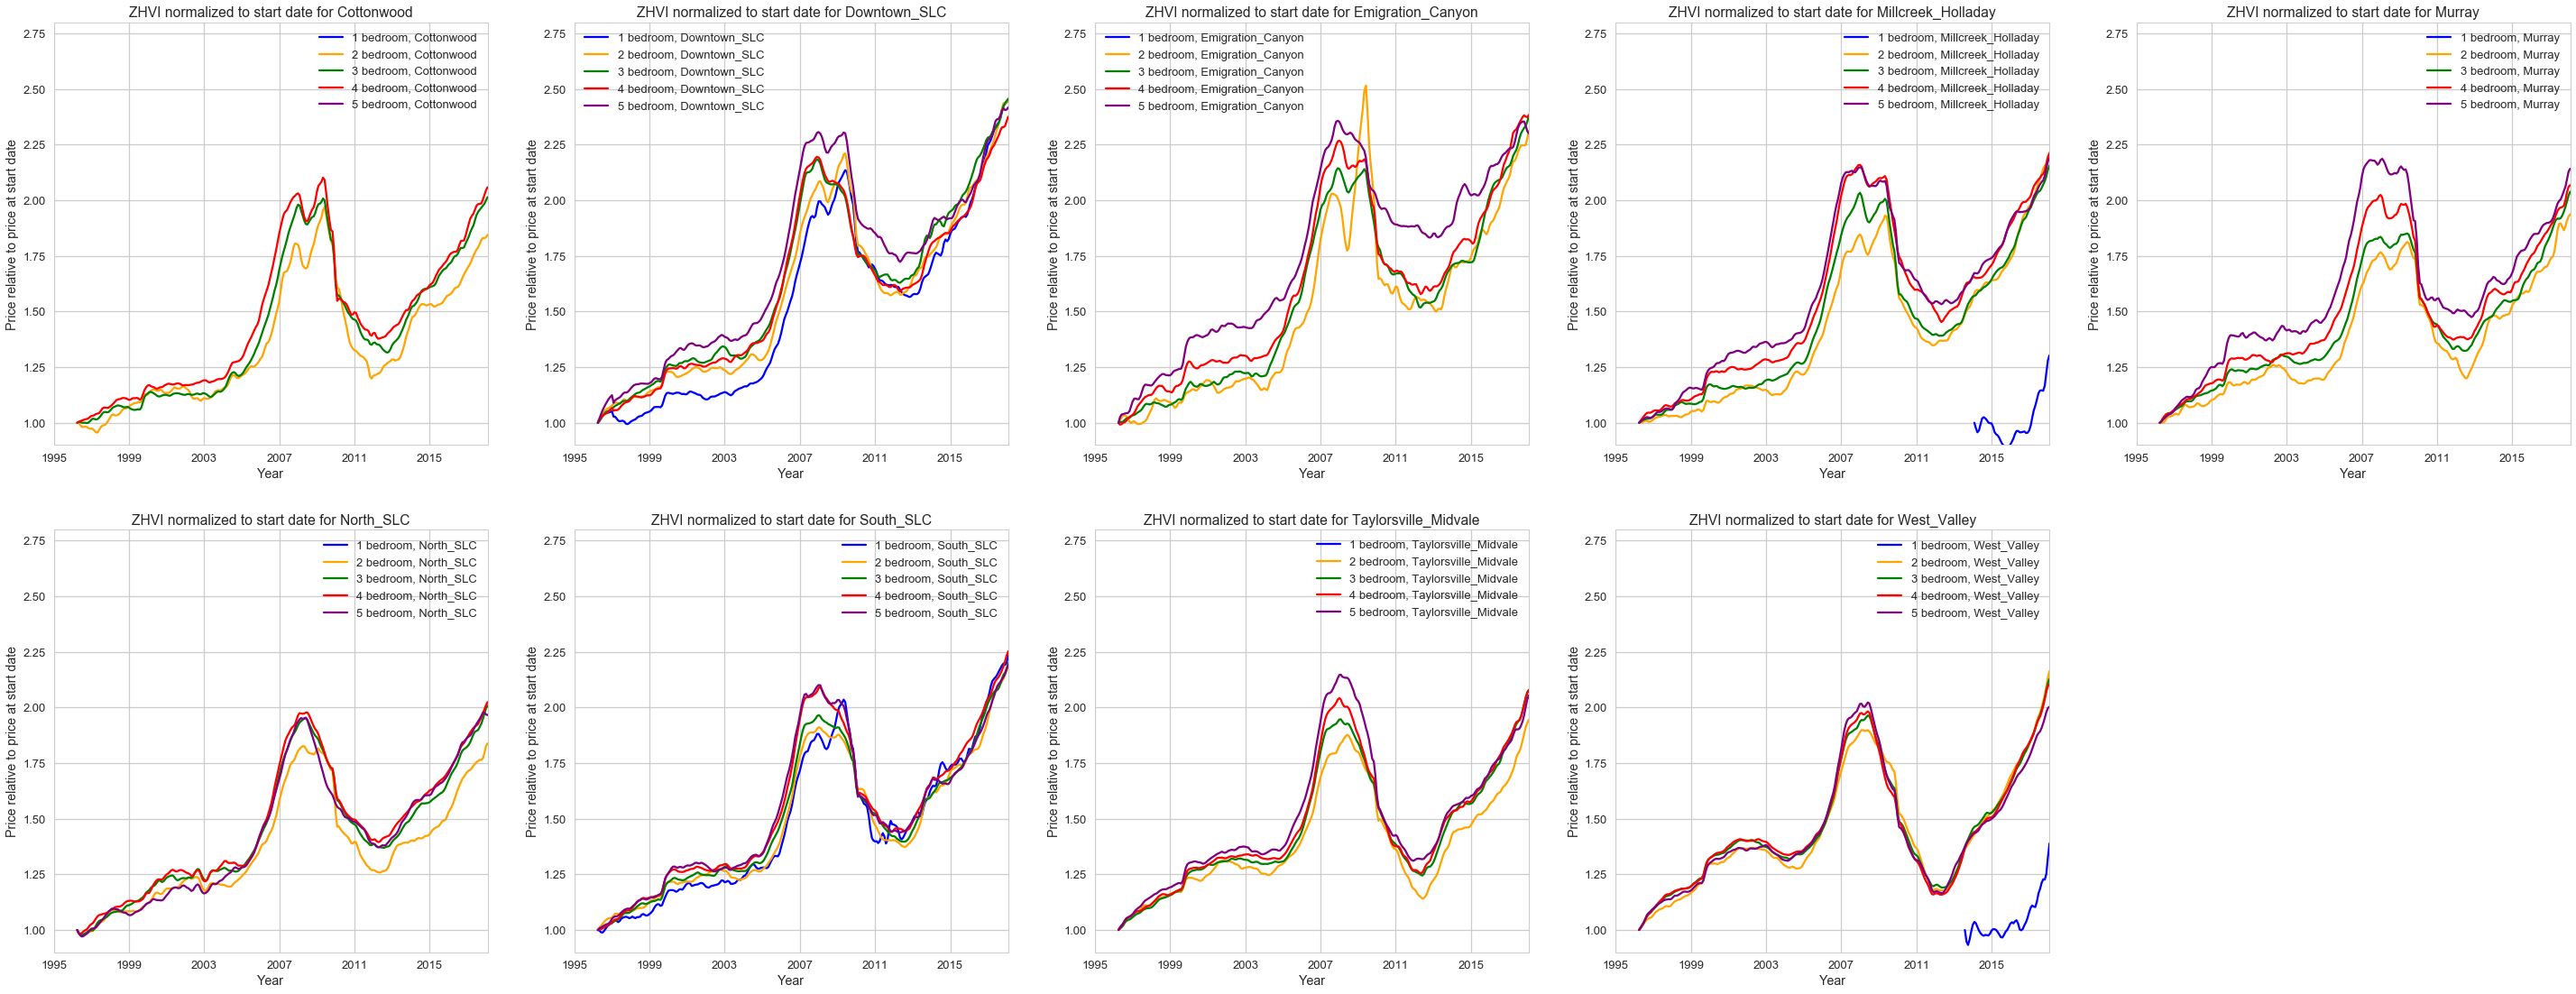

In [244]:
# plot normalized price value across timeseries for all neighborhoods

# make dict of all combinations of neighborhood/bedrooms
neighborhood_list = list(listings_historical_neibs_collapsed['neighborhood'].unique())
bed_list = list(range(1,6))
neighborhood_bed_perms = {k:v for k,v in zip(neighborhood_list, [bed_list]*len(neighborhood_list))}

#make the axes fonts bigger
sns.set_context("talk")
sns.set_style("whitegrid")
fig = plt.figure(figsize=[50, 50])

sub_plot_num = 1

for nb,bds in neighborhood_bed_perms.items():
    neib = nb
    neib_all_beds = listings_historical_neibs_collapsed[(listings_historical_neibs_collapsed['neighborhood'] == 
                                                             nb)].dropna(axis=0, how='any')
    fig.add_subplot(5, 5, sub_plot_num)
    for num in bds:
        beds = num
        neib_num_beds = neib_all_beds[neib_all_beds['beds']==num]
        col=['blue', 'orange', 'green', 'red', 'purple']
        plt.plot(neib_num_beds['year_month'], neib_num_beds['price_normalized'], color = col[num-1], 
                 label='{} bedroom, {}'.format(num, nb))
        plt.title('ZHVI normalized to start date for {}'.format(nb))
        plt.ylabel('Price relative to price at start date')
        plt.xlabel('Year')
        plt.ylim((.9, 2.8)) 
        plt.xlim(datetime.date(1995, 1, 1), datetime.date(2018, 2, 1))
        plt.legend()
    sub_plot_num +=1

In [245]:
listings_historical_slc_long_adjusted.sort_values('price_normalized', ascending=False).head()

,beds,neighborhood,postal_code,region,year_month,price,price_normalized,price_normalized_date
24655,2.0,Downtown_SLC,84101,Central,2018-02-01,336300.0,2.894148,1996-04-01
24561,2.0,Downtown_SLC,84101,Central,2018-01-01,333300.0,2.868330,1996-04-01
24382,5.0,Downtown_SLC,84102,Central,2017-11-01,489400.0,2.865340,1996-04-01
24373,2.0,Downtown_SLC,84101,Central,2017-11-01,332500.0,2.861446,1996-04-01
24467,2.0,Downtown_SLC,84101,Central,2017-12-01,331900.0,2.856282,1996-04-01


In [265]:
# collapse regions with multiple zip codes/neighborhoods to reflect average value within region
listings_historical_region = pd.DataFrame(listings_historical_slc_long_adjusted.groupby(['year_month','region', 'beds']).mean())

listings_historical_region_collapsed = listings_historical_region.reset_index()

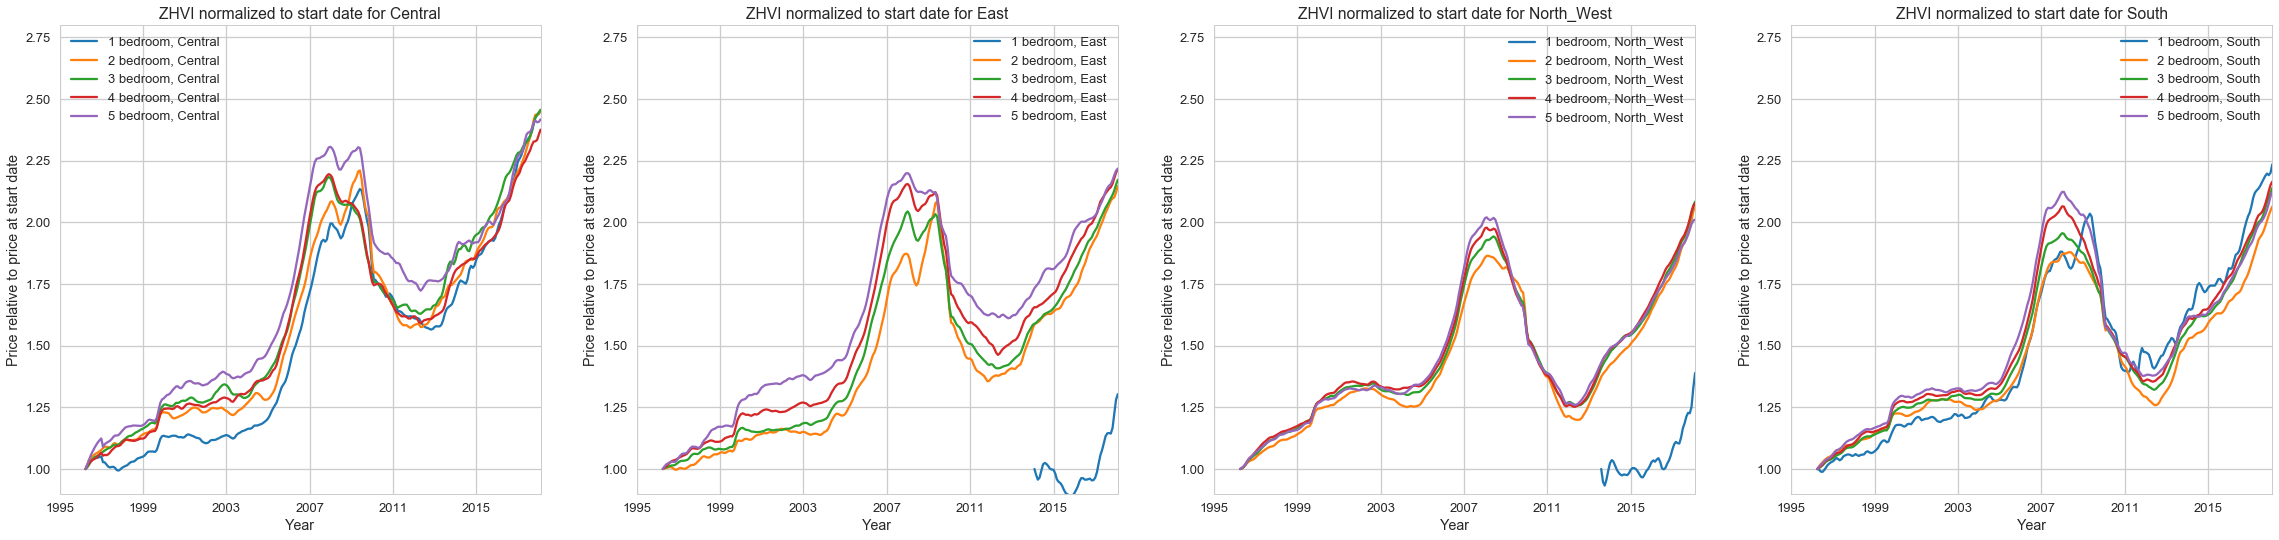

In [247]:
# plot normalized price value across timeseries for all regions

# make dict of all combinations of neighborhood/bedrooms
region_list = list(listings_historical_region_collapsed['region'].unique())
bed_list = list(range(1,6))
region_bed_perms = {k:v for k,v in zip(region_list, [bed_list]*len(region_list))}

#make the axes fonts bigger
sns.set_context("talk")
sns.set_style("whitegrid")
fig = plt.figure(figsize=[50, 50])

sub_plot_num = 1

for rg,bds in region_bed_perms.items():
    region = rg
    region_all_beds = listings_historical_region_collapsed[(listings_historical_region_collapsed['region'] == 
                                                             region)].dropna(axis=0, how='any')
    fig.add_subplot(5, 5, sub_plot_num)
    for num in bds:
        beds = num
        region_num_beds = region_all_beds[region_all_beds['beds']==num]
        plt.plot(region_num_beds['year_month'], region_num_beds['price_normalized'], label='{} bedroom, {}'.format(num, region))
        plt.title('ZHVI normalized to start date for {}'.format(region))
        plt.ylabel('Price relative to price at start date')
        plt.xlabel('Year')
        plt.ylim((.9, 2.8)) 
        plt.xlim(datetime.date(1995, 1, 1), datetime.date(2018, 2, 1))
        plt.legend()
    sub_plot_num +=1

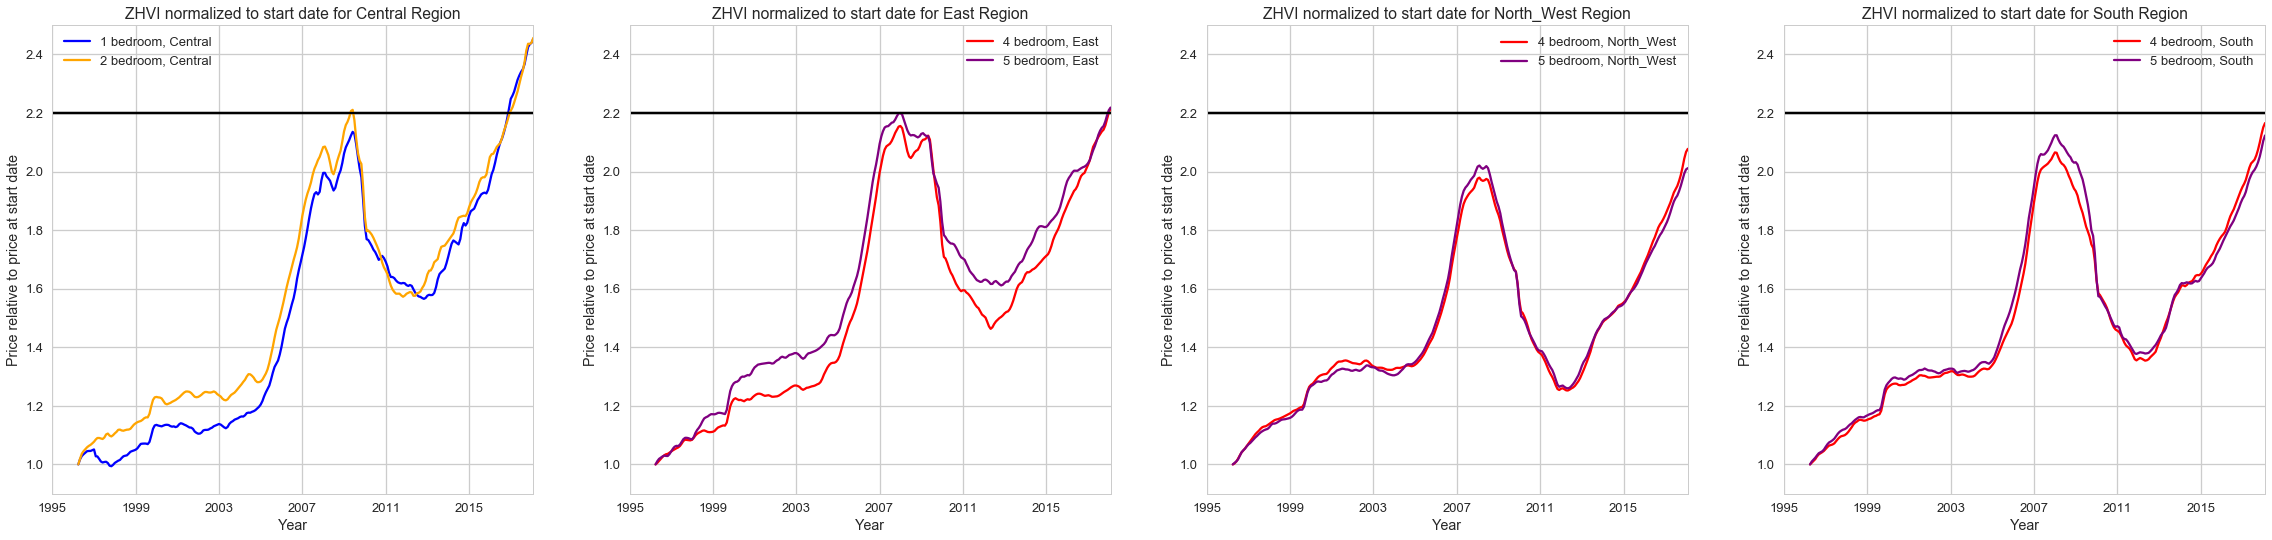

In [255]:
# plot normalized price value across timeseries for urban small homes and suburban large homes

# make dict of all combinations of neighborhood/bedrooms
region_bed_perms_filtered = {'Central': [1, 2],
 'East': [4, 5],
 'North_West': [4, 5],
 'South': [4, 5]}

#make the axes fonts bigger
sns.set_context("talk")
sns.set_style("whitegrid")
fig = plt.figure(figsize=[50, 50])

sub_plot_num = 1

for rg,bds in region_bed_perms_filtered.items():
    region = rg
    region_all_beds = listings_historical_region_collapsed[(listings_historical_region_collapsed['region'] == 
                                                             region)].dropna(axis=0, how='any')
    fig.add_subplot(5, 5, sub_plot_num)
    for num in bds:
        beds = num
        region_num_beds = region_all_beds[region_all_beds['beds']==num]
        col=['blue', 'orange', 'green', 'red', 'purple']
        plt.plot(region_num_beds['year_month'], region_num_beds['price_normalized'], color = col[num-1], label='{} bedroom, {}'.format(num, region))
        plt.title('ZHVI normalized to start date for {} Region'.format(region))
        plt.ylabel('Price relative to price at start date')
        plt.xlabel('Year')
        plt.ylim((.9, 2.5)) 
        plt.xlim(datetime.date(1995, 1, 1), datetime.date(2018, 2, 1))
        plt.axhline(y=2.2, color='black', linestyle='-')
        plt.legend()
    sub_plot_num +=1

In [256]:
listings_historical_slc_long_adjusted.groupby(['region', 'beds'])['price_normalized'].max()

region      beds
Central     1.0     2.543328
            2.0     2.894148
            3.0     2.739467
            4.0     2.441887
            5.0     2.865340
East        1.0     1.303696
            2.0     2.515078
            3.0     2.379674
            4.0     2.384216
            5.0     2.357538
North_West  1.0     1.389392
            2.0     2.326087
            3.0     2.272295
            4.0     2.222965
            5.0     2.186702
South       1.0     2.235417
            2.0     2.277528
            3.0     2.217672
            4.0     2.304936
            5.0     2.291355
Name: price_normalized, dtype: float64

In [257]:
current_date_point = listings_historical_slc_long_adjusted[listings_historical_slc_long_adjusted['year_month'] ==datetime.date(2018, 2, 1)]
current_date_point.sort_values('price_normalized', ascending=False)

,beds,neighborhood,postal_code,region,year_month,price,price_normalized,price_normalized_date
24655,2.0,Downtown_SLC,84101,Central,2018-02-01,336300.0,2.894148,1996-04-01
24664,5.0,Downtown_SLC,84102,Central,2018-02-01,481900.0,2.821429,1996-04-01
24656,3.0,Downtown_SLC,84101,Central,2018-02-01,315800.0,2.715391,1996-04-01
24649,1.0,Downtown_SLC,84105,Central,2018-02-01,293500.0,2.543328,1996-04-01
24651,3.0,Downtown_SLC,84105,Central,2018-02-01,376700.0,2.523108,1996-04-01
24650,2.0,Downtown_SLC,84105,Central,2018-02-01,319400.0,2.468315,1996-04-01
24652,4.0,Downtown_SLC,84105,Central,2018-02-01,424400.0,2.441887,1996-04-01
24663,4.0,Downtown_SLC,84102,Central,2018-02-01,371300.0,2.414174,1996-04-01
24662,3.0,Downtown_SLC,84102,Central,2018-02-01,333000.0,2.413043,1996-04-01
24665,2.0,Downtown_SLC,84111,Central,2018-02-01,220600.0,2.405671,1996-04-01


In [258]:
# generating data for current date for each region and bed type
current_price_by_region = listings_historical_region_collapsed[listings_historical_region_collapsed['year_month'] ==datetime.date(2018, 2, 1)]

current_price_by_region.head()

,year_month,region,beds,postal_code,price,price_normalized
4818,2018-02-01,Central,1.0,84103.000000,277650.000000,2.453072
4819,2018-02-01,Central,2.0,84104.400000,284760.000000,2.456257
4820,2018-02-01,Central,3.0,84104.400000,341780.000000,2.456242
4821,2018-02-01,Central,4.0,84105.250000,421450.000000,2.375927
4822,2018-02-01,Central,5.0,84103.333333,589033.333333,2.417414


## Calculating and exploring a 'volitility index'

In [383]:
# creating an index of the decline in absolute ZHVI during the 2008 housing crisis (from peak value)

region_list = list(listings_historical_region_collapsed['region'].unique())
bed_list = list(range(1,6))
region_bed_perms = {k:v for k,v in zip(region_list, [bed_list]*len(region_list))}

bubble_start = datetime.date(2006, 1, 1)
bubble_end = datetime.date(2009, 1, 1)

decline_start = datetime.date(2009, 1, 1)
decline_end = datetime.date(2013, 1, 1)

# for each location/bed of home normalize to price at starting time stamp and save to dictionary
volitility_index_regions = pd.DataFrame()

for rg,bds in region_bed_perms.items():
    region = rg
    for num in bds:
        beds = num
        region_beds = listings_historical_region_collapsed[(listings_historical_region_collapsed['region'] == region)
                                                                       &(listings_historical_region_collapsed['beds'] == beds)].dropna(axis=0, how='any')
        if len(zipcode_beds) > 0:
            max_price = region_beds[(region_beds['year_month'] > bubble_start) &
                                           (region_beds['year_month'] < bubble_end)]['price'].max()
            min_price = region_beds[(region_beds['year_month'] > decline_start) &
                                           (region_beds['year_month'] < decline_end)]['price'].min()
            volitility_index = -((max_price - min_price)/max_price)*100
            row = [region, beds, volitility_index]
            volitility_index_regions = volitility_index_regions.append(pd.Series(row), ignore_index=True,)
            
volitility_index_regions.columns = ['region', 'beds', 'volitility_index']

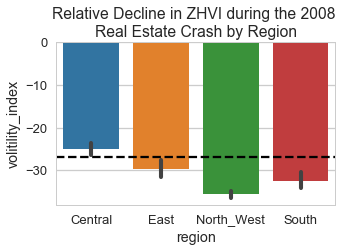

In [384]:
# decline in ZHVI from market peak to valley by region

sns.set_context("talk")
sns.set_style("whitegrid")
fig = plt.figure(figsize=[5,3])

sns.barplot(x="region", y="volitility_index", data=volitility_index_regions)
plt.title('Relative Decline in ZHVI during the 2008 \nReal Estate Crash by Region')
plt.axhline(y=-27, color='black', linestyle='--')
plt.show()

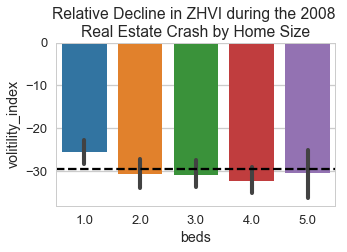

In [385]:
# decline in ZHVI from market peak to valley by bed number

sns.set_context("talk")
sns.set_style("whitegrid")
fig = plt.figure(figsize=[5,3])

sns.barplot(x="beds", y="volitility_index", data=volitility_index_regions)
plt.title('Relative Decline in ZHVI during the 2008 \nReal Estate Crash by Home Size')
plt.axhline(y=-29.5, color='black', linestyle='--')
plt.show()

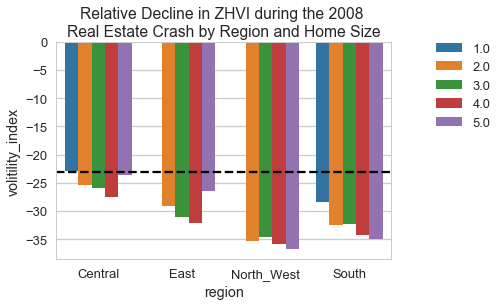

In [387]:
# decline in ZHVI from market peak to valley by bed number and region

sns.set_context("talk")
sns.set_style("whitegrid")
#fig = plt.figure(figsize=[5,5])

ax = sns.barplot(x="region", y="volitility_index", hue='beds', data=volitility_index_regions)
plt.title('Relative Decline in ZHVI during the 2008 \nReal Estate Crash by Region and Home Size')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.axhline(y=-23, color='black', linestyle='--')
plt.show()

In [470]:
# calculating month-month change as an absolute value and percent change

# make dict of all combinations of zip code/bedrooms
zipcode_list = list(listings_historical_slc_long['postal_code'].unique())
bed_list = list(range(1,6))
zipcode_bed_perms = {k:v for k,v in zip(zipcode_list, [bed_list]*len(zipcode_list))}

# for each location/bed of home normalize to price at starting time stamp and save to dictionary
listings_historical_slc_volitility = pd.DataFrame()
for zc,bds in zipcode_bed_perms.items():
    zipcode = zc
    for num in bds:
        beds = num
        zipcode_beds = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == int(zipcode))
                                                                       &(listings_historical_slc_long['beds'] == beds)].dropna(axis=0, how='any').reset_index()
        zipcode_beds['price_change'] = zipcode_beds['price'].diff()
        zipcode_beds['percent_change'] = (zipcode_beds['price'].pct_change()) * 100
    listings_historical_slc_volitility = listings_historical_slc_volitility.append(zipcode_beds)

In [474]:
listings_historical_slc_volitility[listings_historical_slc_volitility['percent_change'] == 
                                  listings_historical_slc_volitility['percent_change'].min()]

,index,beds,neighborhood,postal_code,region,year_month,price,price_change,percent_change
165,15562,5.0,West_Valley,84116,North_West,2010-01-01,164000.0,-12900.0,-7.292256


In [477]:
listings_historical_slc_volitility.groupby('neighborhood')['percent_change'].describe()

,count,mean,std,min,25%,50%,75%,max
neighborhood,,,,,,,,
Downtown_SLC,776.0,0.343068,0.964706,-4.991042,-0.171410,0.300575,0.878399,3.323192
Emigration_Canyon,262.0,0.321522,0.791644,-2.809083,-0.127076,0.186660,0.743517,3.186203
Millcreek_Holladay,786.0,0.303651,0.892904,-4.929930,-0.135671,0.293051,0.741081,3.044248
Murray,262.0,0.296245,1.009155,-7.038123,-0.146399,0.338939,0.841278,3.098739
North_SLC,524.0,0.261024,0.770924,-1.805629,-0.235923,0.343650,0.775137,2.244617
South_SLC,524.0,0.304180,0.939997,-6.721075,-0.116745,0.314796,0.801950,2.705181
Taylorsville_Midvale,524.0,0.280041,0.975033,-7.116279,-0.111304,0.351083,0.737384,2.893891
West_Valley,1310.0,0.270418,0.992507,-7.292256,-0.178128,0.364945,0.835114,3.241413


In [ ]:
# creating an index of the decline in absolute ZHVI during the 2008 housing crisis (from peak value)

region_list = list(listings_historical_region_collapsed['region'].unique())
bed_list = list(range(1,6))
region_bed_perms = {k:v for k,v in zip(region_list, [bed_list]*len(region_list))}

bubble_start = datetime.date(2006, 1, 1)
bubble_end = datetime.date(2009, 1, 1)

decline_start = datetime.date(2009, 1, 1)
decline_end = datetime.date(2013, 1, 1)

# for each location/bed of home normalize to price at starting time stamp and save to dictionary
listings_historical_slc_volitility = pd.DataFrame()

for rg,bds in region_bed_perms.items():
    region = rg
    for num in bds:
        beds = num
        region_beds = listings_historical_region_collapsed[(listings_historical_region_collapsed['region'] == region)
                                                                       &(listings_historical_region_collapsed['beds'] == beds)].dropna(axis=0, how='any')
        if len(zipcode_beds) > 0:
            max_price = region_beds[(region_beds['year_month'] > bubble_start) &
                                           (region_beds['year_month'] < bubble_end)]['price'].max()
            min_price = region_beds[(region_beds['year_month'] > decline_start) &
                                           (region_beds['year_month'] < decline_end)]['price'].min()
            volitility_index = -((max_price - min_price)/max_price)*100
            row = [region, beds, volitility_index]
            volitility_index_regions = volitility_index_regions.append(pd.Series(row), ignore_index=True,)
            
volitility_index_regions_.columns = ['region', 'beds', 'volitility_index']

### Initial exploration of un-normalized data by region

In [71]:
one_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 1)].dropna(axis=0, how='any')
two_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 2)].dropna(axis=0, how='any')
three_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 3)].dropna(axis=0, how='any')
four_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 4)].dropna(axis=0, how='any')
five_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 5)].dropna(axis=0, how='any')

one_bed_downtown = one_bed_downtown.groupby('year_month')['price'].mean()

two_bed_downtown = two_bed_downtown.groupby('year_month')['price'].mean()

three_bed_downtown = three_bed_downtown.groupby('year_month')['price'].mean()

four_bed_downtown = four_bed_downtown.groupby('year_month')['price'].mean()

five_bed_downtown = five_bed_downtown.groupby('year_month')['price'].mean()


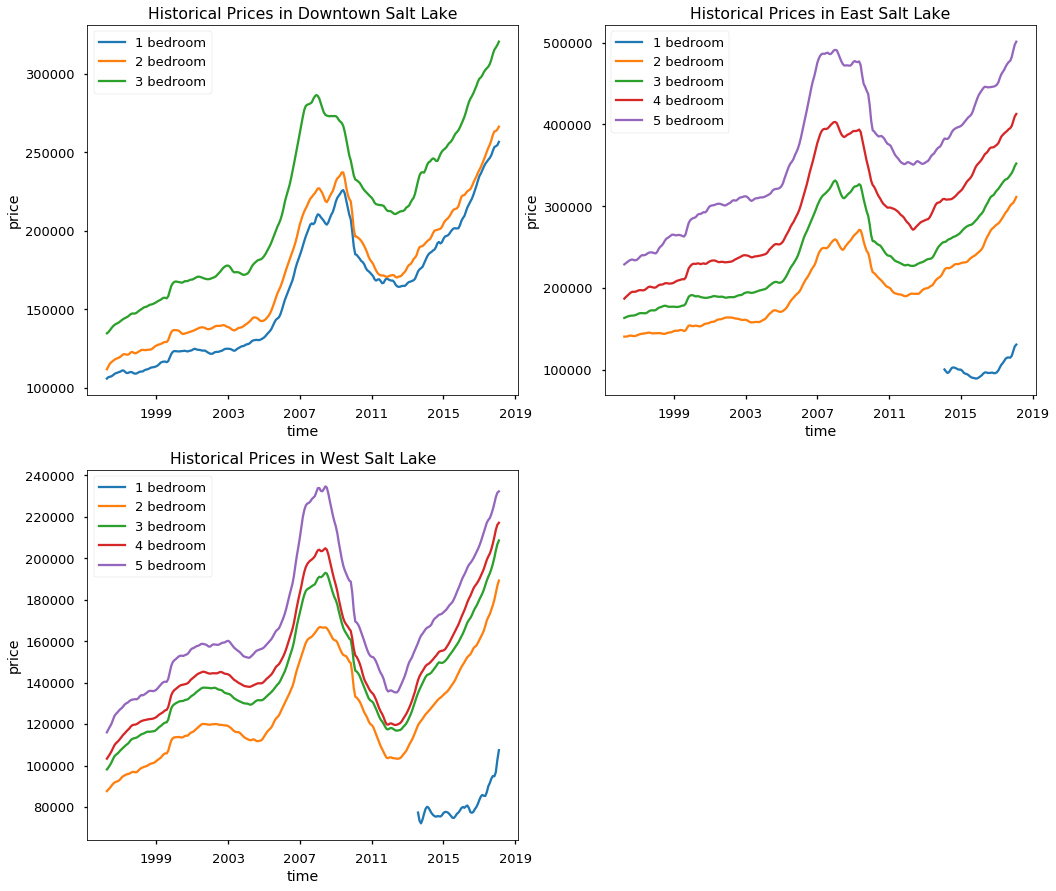

In [72]:
#plot downtown SLC data - DATA NOT NORMALIZED

#make the axes fonts bigger
sns.set_context("talk")
fig = plt.figure(figsize=[17, 15])

# first plot
fig.add_subplot(221)   #top left
plt.plot(one_bed_downtown.index,one_bed_downtown.values, label='1 bedroom')
plt.plot(two_bed_downtown.index,two_bed_downtown.values, label='2 bedroom')
plt.plot(three_bed_downtown.index,three_bed_downtown.values, label='3 bedroom')
#plt.plot(x_84101_4br,y_84101_4br, label='4 bedroom')
#plt.plot(x_84101_5br,y_84101_5br, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices in Downtown Salt Lake')

# second plot
fig.add_subplot(222)   #top left
plt.plot(one_bed_millcreek_holladay.index,one_bed_millcreek_holladay.values, label='1 bedroom')
plt.plot(two_bed_millcreek_holladay.index,two_bed_millcreek_holladay.values, label='2 bedroom')
plt.plot(three_bed_millcreek_holladay.index,three_bed_millcreek_holladay.values, label='3 bedroom')
plt.plot(four_bed_millcreek_holladay.index,four_bed_millcreek_holladay.values, label='4 bedroom')
plt.plot(five_bed_millcreek_holladay.index,five_bed_millcreek_holladay.values, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices in East Salt Lake')

# third plot
fig.add_subplot(223)   #top left
plt.plot(one_bed_west_valley.index,one_bed_west_valley.values, label='1 bedroom')
plt.plot(two_bed_west_valley.index,two_bed_west_valley.values, label='2 bedroom')
plt.plot(three_bed_west_valley.index,three_bed_west_valley.values, label='3 bedroom')
plt.plot(four_bed_west_valley.index,four_bed_west_valley.values, label='4 bedroom')
plt.plot(five_bed_west_valley.index,five_bed_west_valley.values, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices in West Salt Lake')

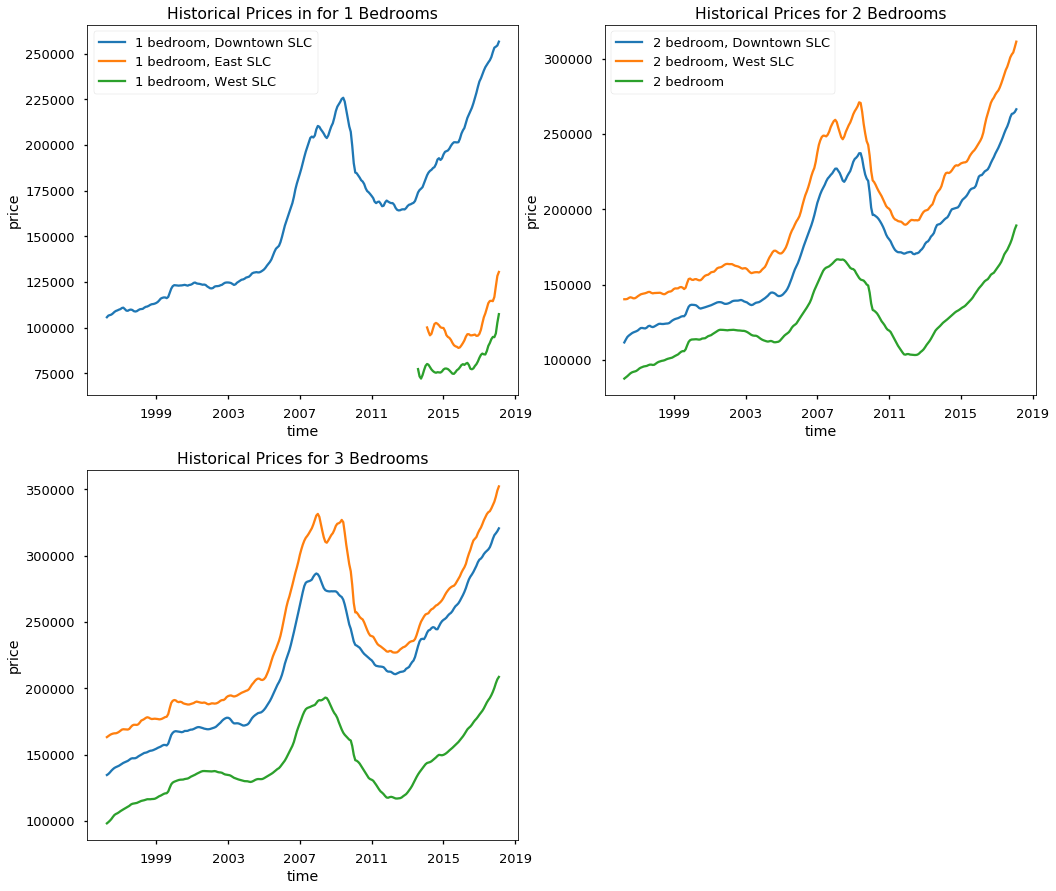

In [73]:
#plot downtown SLC data - DATA NOT NORMALIZED

#make the axes fonts bigger
sns.set_context("talk")
fig = plt.figure(figsize=[17, 15])

# first plot
fig.add_subplot(221)   #top left
plt.plot(one_bed_downtown.index,one_bed_downtown.values, label='1 bedroom, Downtown SLC')
plt.plot(one_bed_millcreek_holladay.index,one_bed_millcreek_holladay.values, label='1 bedroom, East SLC')
plt.plot(one_bed_west_valley.index,one_bed_west_valley.values, label='1 bedroom, West SLC')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices in for 1 Bedrooms')

# second plot
fig.add_subplot(222)   #top left
plt.plot(two_bed_downtown.index,two_bed_downtown.values, label='2 bedroom, Downtown SLC')
plt.plot(two_bed_millcreek_holladay.index,two_bed_millcreek_holladay.values, label='2 bedroom, West SLC')
plt.plot(two_bed_west_valley.index,two_bed_west_valley.values, label='2 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices for 2 Bedrooms')

# third plot
fig.add_subplot(223)   #top left
plt.plot(three_bed_downtown.index,three_bed_downtown.values, label='3 bedroom, Downtown SLC')
plt.plot(three_bed_millcreek_holladay.index,three_bed_millcreek_holladay.values, label='3 bedroom, East SLC')
plt.plot(three_bed_west_valley.index,three_bed_west_valley.values, label='3 bedroom')

plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices for 3 Bedrooms')

In [ ]:
# plot normalized price value across timeseries for all regions

# make dict of all combinations of neighborhood/bedrooms
region_list = list(slc_historic_pricing_region_collapsed['region'].unique())
bed_list = list(range(1,6))
region_bed_perms = {k:v for k,v in zip(region_list, [bed_list]*len(region_list))}

#make the axes fonts bigger
sns.set_context("talk")
sns.set_style("whitegrid")
fig = plt.figure(figsize=[20, 25])
sub_plot_num = 1

for rg,bds in region_bed_perms.items():
    region = rg
    region_all_beds = slc_historic_pricing_region_collapsed[(slc_historic_pricing_region_collapsed['region'] == 
                                                             region)].dropna(axis=0, how='any')
    fig.add_subplot(3, 3, sub_plot_num)
    for num in bds:
        beds = num
        region_num_beds = region_all_beds[region_all_beds['beds']==num]
        col=['blue', 'orange', 'green', 'red', 'purple']
        plt.plot(region_num_beds['year_month'], region_num_beds['price_normalized'], color= col[num-1], label='{} bedroom, {}'.format(num, region))
        plt.title('ZHVI normalized to start date for {}'.format(region))
        plt.ylabel('Price relative to price at start date')
        plt.xlabel('Year')
        plt.axhline(y=2.25, color='black', linestyle='--')
        plt.ylim((.9, 2.8)) 
        plt.xlim(datetime.date(1995, 1, 1), datetime.date(2018, 2, 1))
        plt.legend()
    sub_plot_num +=1

### Plotting un-normalized data by zip code

In [74]:
#creating variables for plotting
x_84101_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 1)]['year_month']
y_84101_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 1)]['price']

x_84101_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 2)]['year_month']
y_84101_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 2)]['price']

x_84101_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 3)]['year_month']
y_84101_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 3)]['price']

x_84101_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 4)]['year_month']
y_84101_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 4)]['price']
                               
x_84101_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 5)]['year_month']
y_84101_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 5)]['price']

In [75]:
#creating variables for plotting 84105

x_84105_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 1)]['year_month']
y_84105_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 1)]['price']

x_84105_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 2)]['year_month']
y_84105_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 2)]['price']

x_84105_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 3)]['year_month']
y_84105_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 3)]['price']

x_84105_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 4)]['year_month']
y_84105_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 4)]['price']
                               
x_84105_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 5)]['year_month']
y_84105_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 5)]['price']

In [76]:
#creating variables for plotting 84106

x_84106_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 1)]['year_month']
y_84106_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 1)]['price']

x_84106_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 2)]['year_month']
y_84106_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 2)]['price']

x_84106_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 3)]['year_month']
y_84106_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 3)]['price']

x_84106_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 4)]['year_month']
y_84106_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 4)]['price']
                               
x_84106_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 5)]['year_month']
y_84106_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)

                                         &(listings_historical_slc_long['beds'] == 5)]['price']

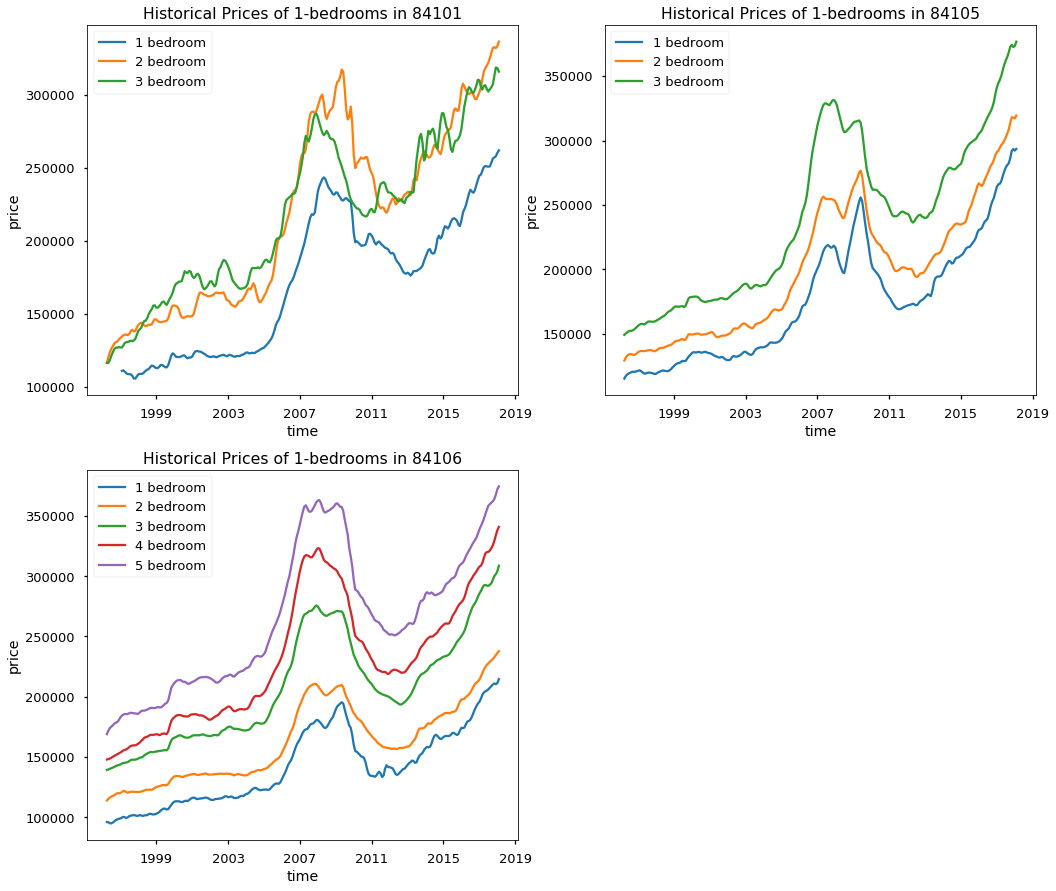

In [77]:
#plot downtown SLC data - DATA NOT NORMALIZED

#make the axes fonts bigger
sns.set_context("talk")
fig = plt.figure(figsize=[17, 15])

# first plot
fig.add_subplot(221)   #top left
plt.plot(x_84101_1br,y_84101_1br, label='1 bedroom')
plt.plot(x_84101_2br,y_84101_2br, label='2 bedroom')
plt.plot(x_84101_3br,y_84101_3br, label='3 bedroom')
#plt.plot(x_84101_4br,y_84101_4br, label='4 bedroom')
#plt.plot(x_84101_5br,y_84101_5br, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices of 1-bedrooms in 84101')

# second plot
fig.add_subplot(222)   #top right
plt.plot(x_84105_1br,y_84105_1br, label='1 bedroom')
plt.plot(x_84105_2br,y_84105_2br, label='2 bedroom')
plt.plot(x_84105_3br,y_84105_3br, label='3 bedroom')
#plt.plot(x_84105_4br,y_84105_4br, label='4 bedroom')
#plt.plot(x_84105_5br,y_84105_5br, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices of 1-bedrooms in 84105')


# third plot
fig.add_subplot(223)   #bottom right
plt.plot(x_84106_1br,y_84106_1br, label='1 bedroom')
plt.plot(x_84106_2br,y_84106_2br, label='2 bedroom')
plt.plot(x_84106_3br,y_84106_3br, label='3 bedroom')
plt.plot(x_84106_4br,y_84106_4br, label='4 bedroom')
plt.plot(x_84106_5br,y_84106_5br, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices of 1-bedrooms in 84106')

plt.show()